# Source: 

- ## https://medium.com/@curiousily/making-a-predictive-keyboard-using-recurrent-neural-networks-tensorflow-for-hackers-part-v-3f238d824218

# Import necessary packages

In [0]:
import sys
import pickle
import heapq
import numpy as np
np.random.seed(42)

In [2]:
import tensorflow as tf
tf.set_random_seed(42)

from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pylab import rcParams
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 12, 5

# Loading the data

In [4]:
! wget https://s3.amazonaws.com/text-datasets/nietzsche.txt

path = 'nietzsche.txt'
text = open(path).read().lower()
print('corpus length: {}'.format(len(text)))

--2019-04-08 11:17:19--  https://s3.amazonaws.com/text-datasets/nietzsche.txt
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.162.69
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.162.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 600901 (587K) [text/plain]
Saving to: ‘nietzsche.txt’

nietzsche.txt       100%[===================>] 586.82K  --.-KB/s    in 0.1s    

2019-04-08 11:17:20 (4.93 MB/s) - ‘nietzsche.txt’ saved [600901/600901]

corpus length: 600893


# Preprocessing

In [5]:
chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

print('unique chars: {}'.format(len(chars)))

unique chars: 57


In [6]:
# Limit the sentences length to chunks of seq_length characters
seq_length = 40

# Spaces between sentences
step = 3

# List to store the sentences
sentences = []

# List to store the next character to be predicted for each sentence
next_chars = []
for i in range(0, len(text) - seq_length, step):
    sentences.append(text[i: i + seq_length])
    next_chars.append(text[i + seq_length])
print('num training examples: {}'.format(len(sentences)))

num training examples: 200285


In [0]:
# Create one-hot-encoded vectors
X = np.zeros((len(sentences), seq_length, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)

for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [8]:
# Show 
print('Example of a single training sequence:\n {}\n'.format(sentences[100]))
print('Character to be predicted for it:\n {}'.format(next_chars[100]))

Example of a single training sequence:
 ve been unskilled and unseemly methods f

Character to be predicted for it:
 o


In [9]:
print('Training examples:\t{}\nSequence length:\t{}\nUnique chars:\t\t{}'.format(X.shape[0], X.shape[1], X.shape[2]))
print(X[0][0])

Training examples:	200285
Sequence length:	40
Unique chars:		57
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False  True False False False False False
 False False False False False False False False False]


In [10]:
print('Training examples:\t{}\nUnique chars:\t\t{}'.format(X.shape[0], X.shape[1], X.shape[2]))
print(y[0])

Training examples:	200285
Unique chars:		40
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True False False False False False False False
 False False False False False False False False False]


# Building the model

In [0]:
vocab_size = len(chars)

In [12]:
model = Sequential()
model.add(LSTM(128, input_shape=(seq_length, len(chars))))
model.add(Dense(vocab_size))
model.add(Activation('softmax'))
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               95232     
_________________________________________________________________
dense_1 (Dense)              (None, 57)                7353      
_________________________________________________________________
activation_1 (Activation)    (None, 57)                0         
Total params: 102,585
Trainable params: 102,585
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [13]:
# Set the optimizer
optimizer = RMSprop(lr=0.01)

# Compile the network
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Fit the network
history = model.fit(X, y, validation_split=0.05, batch_size=128, epochs=20, shuffle=True).history

Instructions for updating:
Use tf.cast instead.
Train on 190270 samples, validate on 10015 samples
Epoch 1/20
190270/190270 [==============================] - 144s 757us/step - loss: 1.9851 - acc: 0.4199 - val_loss: 1.6905 - val_acc: 0.4895
Epoch 2/20
190270/190270 [==============================] - 141s 739us/step - loss: 1.6412 - acc: 0.5129 - val_loss: 1.5945 - val_acc: 0.5178
Epoch 3/20
190270/190270 [==============================] - 140s 737us/step - loss: 1.5516 - acc: 0.5380 - val_loss: 1.5512 - val_acc: 0.5331
Epoch 4/20
190270/190270 [==============================] - 139s 729us/step - loss: 1.5071 - acc: 0.5494 - val_loss: 1.5435 - val_acc: 0.5370
Epoch 5/20
190270/190270 [==============================] - 137s 721us/step - loss: 1.4748 - acc: 0.5576 - val_loss: 1.5319 - val_acc: 0.5459
Epoch 6/20
190270/190270 [==============================] - 140s 734us/step - loss: 1.4546 - acc: 0.5644 - val_loss: 1.5103 - val_acc: 0.5476
Epoch 7/20
190270/190270 [=======================

In [0]:
# Save the model
model.save('keras_model.h5')
pickle.dump(history, open('history.p', 'wb'))

In [0]:
# Load the model
model = load_model('keras_model.h5')
history = pickle.load(open('history.p', 'rb'))

## Evaluation

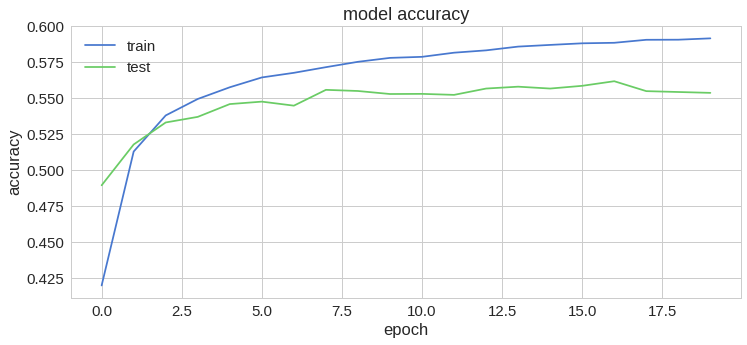

In [17]:
# Model accuracy
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

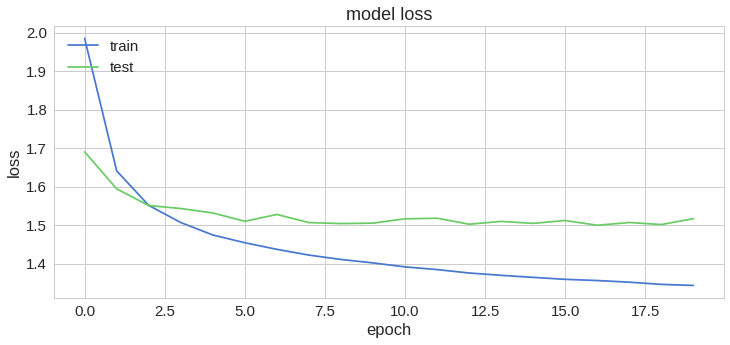

In [18]:
# Model loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

# Test

In [0]:
example_sentence = 'This is an example of input for our LSTM'

In [0]:
def prepare_input(text):
    text = text.lower()
    x = np.zeros((1, seq_length, len(chars)))

    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
        
    return x

In [21]:
prepare_input(example_sentence)

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [0]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [0]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]

        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

In [0]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

In [0]:
quotes = [
    "It is not a lack of love, but a lack of friendship that makes unhappy marriages.",
    "That which does not kill us makes us stronger.",
    "I'm not upset that you lied to me, I'm upset that from now on I can't believe you.",
    "And those who were seen dancing were thought to be insane by those who could not hear the music.",
    "It is hard enough to remember my opinions, without also remembering my reasons for them!"
]

In [26]:
for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()

it is not a lack of love, but a lack of 
['the ', 'an ', 'present ', 'such ', 'its ']

that which does not kill us makes us str
['ong ', 'ength ', 'ives ', 'ange ', 'uctume ']

i'm not upset that you lied to me, i'm u
['nder ', 's ', 'pon ', 'tterness ', 'ltimation ']

and those who were seen dancing were tho
['ught ', 'se ', 'rough ', 'ngme ', 'wer ']

it is hard enough to remember my opinion
[' of ', ', ', 's ', '. ', '\nand ']

